We will use a built-in dataset, in netCDF format, to practice using `xarray`, looking at temperature anomalies for the contiguous United States.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

xr.set_options(keep_attrs=True, display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go

In [2]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
temperature = ds['air']
temperature

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
[3869000 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [4]:
max_temp = temperature.max(dim='time')
min_temp = temperature.min(dim='time')
mean_temp = temperature.mean(dim='time')
mean_temp_c = mean_temp - 273.15
mean_temp_c['units'] = 'degC'
temperature_c = temperature - 273.15
temperature_c['units'] = 'degC'
anomalies_c = temperature_c - mean_temp_c
anomalies_c.attrs['units'] = 'degC'
anomalies_c

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
-19.18 -17.68 -16.39 -15.48 -14.92 ... -0.5012 -0.6276 -0.8482 -1.091 -1.615
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
    units    <U4 16B 'degC'
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degC
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

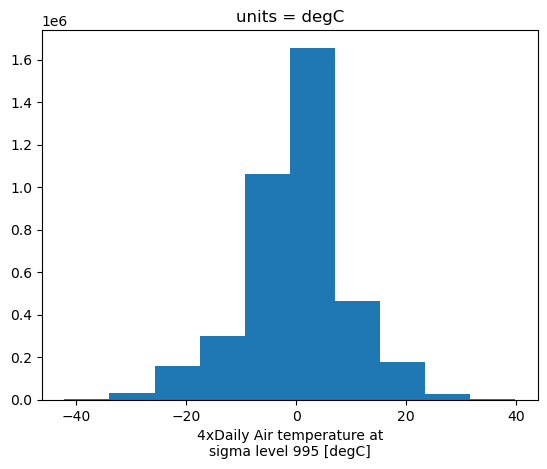

In [5]:
anomalies_c.plot()
plt.show()

(array([ 230., 1952., ..., 1832.,   69.]),
 array([-52.15, -47.33, ...,  39.43,  44.25]),
 <BarContainer object of 20 artists>)

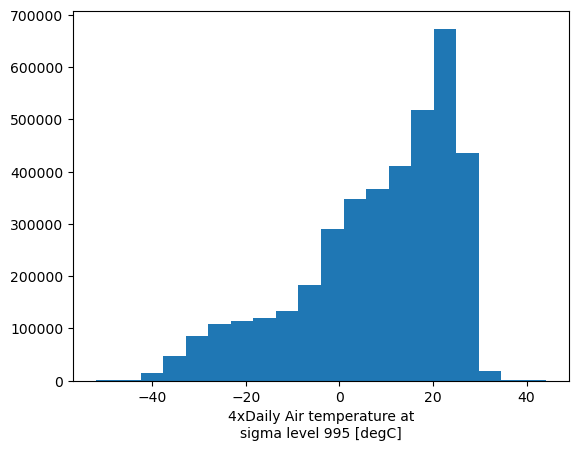

In [6]:
deg_c = temperature - 273.15

deg_c.attrs['units'] = 'degC'
deg_c.plot(bins=20)

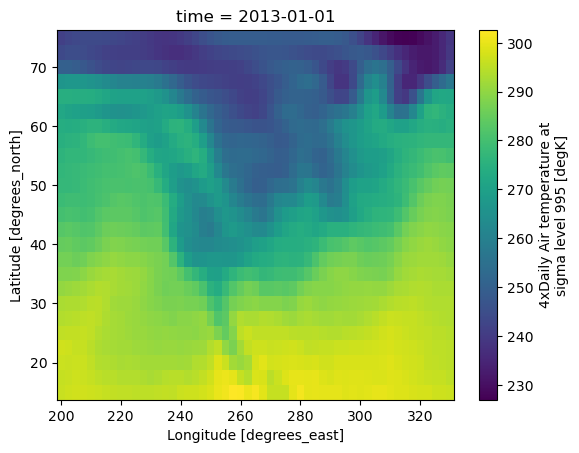

In [7]:
ds.air.isel(time=0).plot(x="lon")

<Figure size 800x800 with 0 Axes>

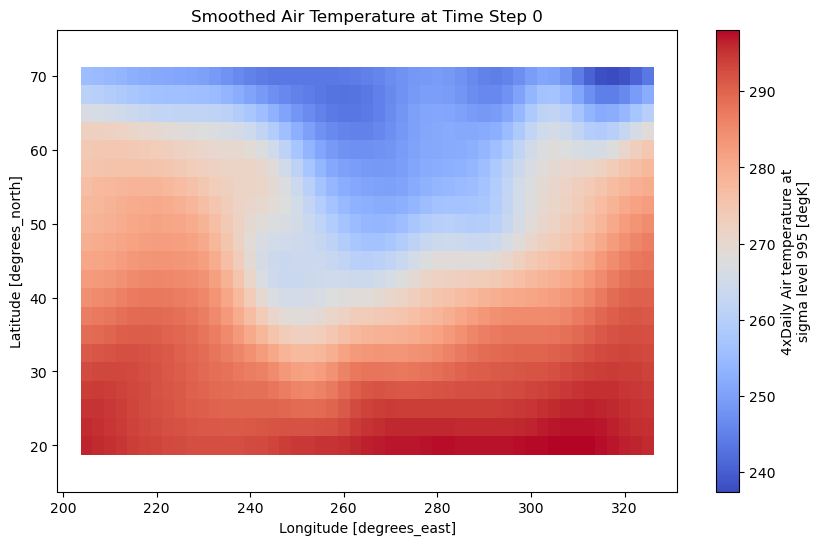

In [8]:
lat_window = 5
lon_window = 5

plt.figure(figsize=(8,8))
smoothed_ds = ds.rolling(lat=lat_window, lon=lon_window, center=True).mean()

time_0 = smoothed_ds.isel(time=0)

time = 0
plt.figure(figsize=(10, 6))
time_0['air'].plot(cmap='coolwarm')
plt.title(f'Smoothed Air Temperature at Time Step {time}')
plt.show()

In [12]:
# create dash app
app = dash.Dash(__name__)

# App layout
app.layout = html.Div([
    html.H1("Air Temperature Visualization with Basemap"),
    dcc.Slider(
        id='time-slider',
        min=0,
        max=len(smoothed_ds.time) - 1,
        step=1,
        value=0,
        marks={i: f'Time {i}' for i in range(0, len(smoothed_ds.time), 10)},
    ),
    dcc.Graph(id='temperature-plot'),
])

# Callback to update the plot based on the slider value
@app.callback(
    Output('temperature-plot', 'figure'),
    [Input('time-slider', 'value')]
)
def update_plot(time_step):
    data = smoothed_ds.isel(time=time_step)

    # Replace NaN values with a placeholder
    air_data = data['air'].fillna(0)

    # Create a geographic plot
    fig = go.Figure()

    # Add temperature data as a heatmap
    fig.add_trace(go.Heatmap(
        z=air_data.values,
        x=data['lon'].values,
        y=data['lat'].values,
        colorscale='coolwarm',
        colorbar=dict(title='Temperature'),
    ))

    # Update the layout to include a basemap
    fig.update_layout(
        title=f"Temperature at Time Step {time_step}",
        geo=dict(
            showland=True,
            showcountries=True,
            showcoastlines=True,
            projection_type='equirectangular',
        ),
        xaxis=dict(title='Longitude'),
        yaxis=dict(title='Latitude'),
        height=600,
        width=800,
    )
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[12], line 33, in update_plot(time_step=0)
     30 fig = go.Figure()
     32 # Add temperature data as a heatmap
---> 33 fig.add_trace(go.Heatmap(
        fig = Figure({
    'data': [], 'layout': {'template': '...'}
})
        go = <module 'plotly.graph_objects' from '/Applications/Anaconda/anaconda3/envs/geo_dash/lib/python3.11/site-packages/plotly/graph_objects/__init__.py'>
        air_data = <xarray.DataArray 'air' (lat: 25, lon: 53)> Size: 11kB
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
    time     datetime64[ns] 8B 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         